# 4. Final version: GridSearchCV & Feature Selection (Backward Elimination)

- 그리드서치CV를 이용한 최적의 하이퍼파라미터로 튜닝
- 이후 각 모델마다 후진제거방법으로 피처 셀렉션

## 01-1. import와 모델링 전 컬럼 전처리(이전 버전과 동일)

In [31]:
# 모듈 불러오기
import pandas as pd
import numpy as np
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

from model import *
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import learning_curve

In [32]:
# 데이터 불러오기
df = pd.read_excel('../data/file/ml_all.xlsx', index_col=0)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 601 entries, 0 to 600
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   korean_title                  601 non-null    object 
 1   english_title                 601 non-null    object 
 2   year                          601 non-null    int64  
 3   total_season_num              601 non-null    int64  
 4   runtime                       601 non-null    int64  
 5   genre                         601 non-null    object 
 6   age_rating                    601 non-null    int64  
 7   production_country            601 non-null    object 
 8   PCA                           601 non-null    float64
 9   genre_len                     601 non-null    int64  
 10  production_country_freq_code  601 non-null    int64  
 11  production_country_code       601 non-null    int64  
 12  seson_n                       601 non-null    int64  
 13  i_s1_rate 

In [33]:
# 각 범주(나라)의 타겟 변수(여기서는 runtime의 평균) 계산
country_means = df.groupby('production_country')['PCA'].mean()

# 타겟 인코딩 적용
df['production_country_encoded'] = df['production_country'].map(country_means)

In [34]:
# 넷플릭스 장르 선호도 순위 리스트 (선호도 순서대로 정렬)
genres = [
    '드라마', '코미디', 'SF', '액션', '스릴러', '범죄', '공포', '로맨스', '판타지', '전쟁', '서부', '그 외'
]

# 각 장르에 점수를 선형적으로 할당하여 딕셔너리로 만들기
genre_scores = {genre: 1 - i / (len(genres)) for i, genre in enumerate(genres)}

# '그 외'에 해당되는 장르 리스트
other_genres = ['역사', '가족', '음악', 'Made in Europe', '스포츠']

# 장르 문자열을 받아서 점수를 계산하는 함수

def get_genre_score(genre_str):
    # 장르를 ', '로 분리
    genre_list = genre_str.split(', ')
    
    # '그 외'에 포함된 하위 장르가 있는지 확인
    for genre in genre_list:
        if genre in other_genres:
            return genre_scores['그 외']
    
    # 각 장르의 점수의 평균 계산
    total_score = 0
    count = 0
    for genre in genre_list:
        score = genre_scores.get(genre, genre_scores['그 외'])  # 없는 장르는 '그 외' 점수로 처리
        total_score += score
        count += 1
    
    # 평균 점수 계산
    average_score = total_score / count if count > 0 else 0
    return average_score

# 장르별 점수
df['genre'] = df['genre'].apply(get_genre_score)

In [35]:
# 로그 변환 적용 

df['i_s2_rate_cnt'] = np.log1p(df['i_s2_rate_cnt'])  # log(1+x) 변환 사용
df['w_s2_rate_cnt'] = np.log1p(df['w_s2_rate_cnt'])
df['s2_rate_cnt_retention'] = np.log1p(df['s2_rate_cnt_retention'])
df['s1_gap_days'] = np.log1p(df['s1_gap_days'])
df['age_rating'] = np.log1p(df['age_rating'])
df['season_gaps_days'] = np.log1p(df['season_gaps_days'])
df['i_s1_rate_cnt'] = np.log1p(df['i_s1_rate_cnt'])  # log(1+x) 변환 사용
df['w_s1_rate_cnt'] = np.log1p(df['w_s1_rate_cnt'])
df['s1_rate_cnt_retention'] = np.log1p(df['s1_rate_cnt_retention'])

In [36]:
# y값(흥행도)

# 각 요소 계산
rate = (0.8 * df['i_s2_rate']) + (0.2 * df['w_s2_rate'])
cnt = (0.8 * df['i_s2_rate_cnt']) + (0.2 * df['w_s2_rate_cnt'])
ret = (0.4 * df['s2_rate_retention']) + (0.6 * df['s2_rate_cnt_retention'])

# 총 점수 계산
total = (0.3 * rate + 0.5 * cnt + 0.2 * ret) *10

# 점수를 데이터프레임에 추가
df['score'] = total

---

## 02-1. GridSearchCV('model.py'이용) 후 Feature Selection 모델링

In [37]:
# 후진 제거 피처 셀렉션 함수
def backward_elimination(model, X_train, y_train, X_test, y_test):
    features = X_train.columns.tolist()
    best_mse = mean_squared_error(y_test, model.fit(X_train, y_train).predict(X_test))
    best_features = features.copy()

    while len(best_features) > 0:
        worst_feature = None
        worst_mse = best_mse

        for feature in best_features:
            temp_features = best_features.copy()
            temp_features.remove(feature)

            X_train_temp = X_train[temp_features]
            X_test_temp = X_test[temp_features]
            model.fit(X_train_temp, y_train)
            mse = mean_squared_error(y_test, model.predict(X_test_temp))

            if mse < worst_mse:
                worst_mse = mse
                worst_feature = feature

        if worst_feature is not None:
            best_features.remove(worst_feature)
            best_mse = worst_mse
        else:
            break

    print(f"Selected Features: {best_features}")
    print("=" * 40)
    return best_mse, best_features

In [38]:
df_1 = df[['runtime','genre','age_rating','production_country_encoded','PCA','genre_len','seson_n','i_s1_rate','i_s1_rate_cnt','s1_rate_retention','s1_rate_cnt_retention','w_s1_rate','w_s1_rate_cnt','s1_gap_days','season_gaps_days','score']]

In [39]:
X = df_1.drop(['score'], axis=1)  # 'score' 열을 제외한 모든 열 선택
y = df_1['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [40]:
# DecisionTreeRegressor 모델과 파라미터 가져오기
model_name = 'DecisionTreeRegressor'
model, param_grid = models[model_name]

# GridSearchCV를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_dt, best_params_dt = grid_search(X_train, y_train, model, param_grid)

# 후진 제거 피처 셀렉션을 수행합니다
best_mse, best_features = backward_elimination(best_dt, X_train, y_train, X_test, y_test)

# 선택된 피처로 모델을 다시 훈련합니다
best_dt.fit(X_train[best_features], y_train)

# 최적의 모델을 평가합니다
dt_mae, dt_mse, dt_r2 = evaluate(best_dt, X_test[best_features], y_test)
print(f"Best Parameters: {best_params_dt}")

Selected Features: ['age_rating', 'genre_len', 'seson_n', 'i_s1_rate', 'i_s1_rate_cnt', 's1_rate_retention', 's1_rate_cnt_retention', 'w_s1_rate_cnt', 's1_gap_days']
MAE: 2.1912676679257728
MSE: 7.945078813151462
R^2: 0.9082848800667569
Best Parameters: {'max_depth': 7, 'min_samples_split': 25}


In [41]:
# RandomForestRegressor 모델과 파라미터 가져오기
model_name = 'RandomForestRegressor'
model, param_grid = models[model_name]

# GridSearchCV를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_rf, best_params_rf = grid_search(X_train, y_train, model, param_grid)

# 후진 제거 피처 셀렉션을 수행합니다
best_mse, best_features = backward_elimination(best_rf, X_train, y_train, X_test, y_test)

# 선택된 피처로 모델을 다시 훈련합니다
best_rf.fit(X_train[best_features], y_train)

# 최적의 모델을 평가합니다
rf_mae, rf_mse , rf_r2 = evaluate(best_rf, X_test[best_features], y_test)
print(f"Best Parameters: {best_params_rf}")

Selected Features: ['genre', 'production_country_encoded', 'genre_len', 'i_s1_rate', 'i_s1_rate_cnt', 's1_rate_cnt_retention', 'w_s1_rate', 'w_s1_rate_cnt', 's1_gap_days', 'season_gaps_days']
MAE: 1.4943579391044906
MSE: 3.957952986601397
R^2: 0.9543108203967209
Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 350}


In [42]:
# KNeighborsRegressor 모델과 파라미터 가져오기
model_name = 'KNeighborsRegressor'
model, param_grid = models[model_name]

# GridSearchCV를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_knn, best_params_knn = grid_search(X_train, y_train, model, param_grid)

# 후진 제거 피처 셀렉션을 수행합니다
best_mse, best_features = backward_elimination(best_knn, X_train, y_train, X_test, y_test)

# 선택된 피처로 모델을 다시 훈련합니다
best_knn.fit(X_train[best_features], y_train)

# 최적의 모델을 평가합니다
knn_mae, knn_mse , knn_r2 =evaluate(best_knn, X_test[best_features], y_test)
print(f"Best Parameters: {best_params_knn}")

Selected Features: ['genre', 'i_s1_rate', 'i_s1_rate_cnt', 's1_rate_retention', 'w_s1_rate', 'w_s1_rate_cnt', 'season_gaps_days']
MAE: 1.5705341844883782
MSE: 3.9160220087988042
R^2: 0.954794856458354
Best Parameters: {'n_neighbors': 5, 'weights': 'distance'}


In [43]:
# XGBRegressor 모델과 파라미터 가져오기
model_name = 'XGBRegressor'
model, param_grid = models[model_name]

# GridSearchCV를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_xgb, best_params_xgb = grid_search(X_train, y_train, model, param_grid)

# 후진 제거 피처 셀렉션을 수행합니다
best_mse, best_features = backward_elimination(best_xgb, X_train, y_train, X_test, y_test)

# 선택된 피처로 모델을 다시 훈련합니다
best_xgb.fit(X_train[best_features], y_train)

# 최적의 모델을 평가합니다
xgb_mae, xgb_mse, xgb_r2 = evaluate(best_xgb, X_test[best_features], y_test)
print(f"Best Parameters: {best_params_xgb}")

Selected Features: ['genre', 'production_country_encoded', 'PCA', 'genre_len', 'i_s1_rate', 'i_s1_rate_cnt', 's1_rate_cnt_retention', 'w_s1_rate', 'w_s1_rate_cnt', 's1_gap_days', 'season_gaps_days']
MAE: 1.3926498661704696
MSE: 3.296098246009696
R^2: 0.961951032449907
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [44]:
# AdaBoostRegressor 모델과 파라미터 가져오기
model_name = 'AdaBoostRegressor'
model, param_grid = models[model_name]

# GridSearchCV를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_ada, best_params_ada = grid_search(X_train, y_train, model, param_grid)

# 후진 제거 피처 셀렉션을 수행합니다
best_mse, best_features = backward_elimination(best_ada, X_train, y_train, X_test, y_test)

# 선택된 피처로 모델을 다시 훈련합니다
best_ada.fit(X_train[best_features], y_train)

# 최적의 모델을 평가합니다
ada_mae, ada_mse, ada_r2 = evaluate(best_ada, X_test[best_features], y_test)
print(f"Best Parameters: {best_params_ada}")

Selected Features: ['runtime', 'genre', 'age_rating', 'production_country_encoded', 'genre_len', 'seson_n', 'i_s1_rate', 'i_s1_rate_cnt', 's1_rate_retention', 's1_rate_cnt_retention', 'w_s1_rate', 'w_s1_rate_cnt', 's1_gap_days']
MAE: 1.915260398377656
MSE: 5.894957520172797
R^2: 0.931950739737273
Best Parameters: {'learning_rate': 0.2, 'n_estimators': 200}


In [ ]:
# LGBMRegressor 모델과 파라미터 가져오기
model_name = 'LGBMRegressor'
model, param_grid = models[model_name]

# GridSearchCV를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_lgb, best_params_lgb = grid_search(X_train, y_train, model, param_grid)

# 후진 제거 피처 셀렉션을 수행합니다
best_mse, best_features = backward_elimination(best_lgb, X_train, y_train, X_test, y_test)

# 선택된 피처로 모델을 다시 훈련합니다
best_lgb.fit(X_train[best_features], y_train)

# 최적의 모델을 평가합니다
lgb_mae, lgb_mse, lgb_r2 = evaluate(best_lgb, X_test[best_features], y_test)

In [46]:
print(f"Best Parameters: {best_params_lgb}")

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


In [47]:
# GradientBoostingRegressor 모델과 파라미터 가져오기
model_name = 'GradientBoostingRegressor'
model, param_grid = models[model_name]

# GridSearchCV를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_gbr, best_params_gbr = grid_search(X_train, y_train, model, param_grid)

# 후진 제거 피처 셀렉션을 수행합니다
best_mse, best_features = backward_elimination(best_gbr, X_train, y_train, X_test, y_test)

# 선택된 피처로 모델을 다시 훈련합니다
best_gbr.fit(X_train[best_features], y_train)

# 최적의 모델을 평가합니다
gbr_mae, gbr_mse, gbr_r2 = evaluate(best_gbr, X_test[best_features], y_test)
print(f"Best Parameters: {best_params_gbr}")

Selected Features: ['runtime', 'genre', 'age_rating', 'production_country_encoded', 'genre_len', 'i_s1_rate', 'i_s1_rate_cnt', 's1_rate_cnt_retention', 'w_s1_rate', 'w_s1_rate_cnt', 's1_gap_days', 'season_gaps_days']
MAE: 1.3363325573448606
MSE: 2.9968706287950004
R^2: 0.965405207977374
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


{'runtime': 0.00023629364979239962, 'genre': 0.0017547140008093277, 'age_rating': 5.3052897926232635e-05, 'production_country_encoded': 0.004175244102065223, 'genre_len': 0.0005475415288776067, 'i_s1_rate': 0.03137565608395648, 'i_s1_rate_cnt': 0.8446974871288873, 's1_rate_cnt_retention': 0.002653289147969724, 'w_s1_rate': 0.0219480064029687, 'w_s1_rate_cnt': 0.08676889904872125, 's1_gap_days': 0.0033187274940088625, 'season_gaps_days': 0.002471088514017228}


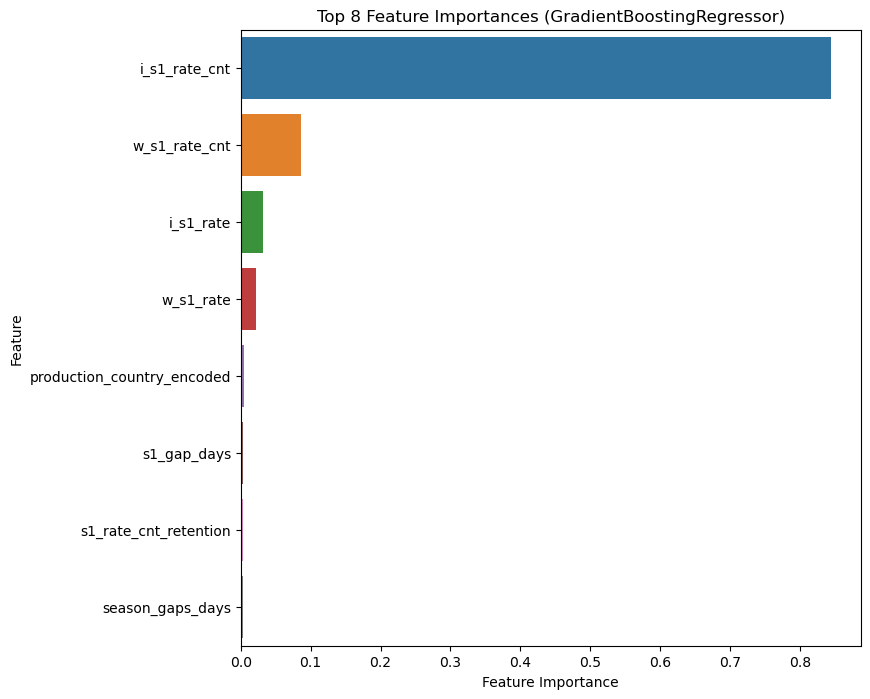

In [48]:
# 특성 중요도 확인
feature_importances_gbr = best_gbr.feature_importances_
importances_dict_gbr = dict(zip(X_train[best_features], feature_importances_gbr))
print(importances_dict_gbr)

# 중요도가 높은 상위 8개의 컬럼 선택
best_cols_gbr = pd.Series(feature_importances_gbr, index=X_train[best_features].columns)
top_cols_gbr = best_cols_gbr.sort_values(ascending=False)[:8]

# 시각화
plt.figure(figsize=(8, 8))
sns.barplot(x=top_cols_gbr, y=top_cols_gbr.index)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 8 Feature Importances (GradientBoostingRegressor)')
plt.show()

In [49]:
# LinearRegression 모델에 대해 후진 제거 피처 셀렉션 수행
best_mse_lr, best_features_lr = backward_elimination(LinearRegression(), X_train, y_train, X_test, y_test)

# 선택된 특성들로 LinearRegression 모델 학습 및 평가
X_train_selected_lr = X_train[best_features_lr]
X_test_selected_lr = X_test[best_features_lr]

lr_model = LinearRegression()
lr_model.fit(X_train_selected_lr, y_train)
y_pred_lr = lr_model.predict(X_test_selected_lr)

lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

print("LinearRegression 모델 성능 평가:")
print(f"MSE: {lr_mse}")
print(f"MAE: {lr_mae}")
print(f"R^2: {lr_r2}")
print(f"Selected Features: {best_features_lr}")

Selected Features: ['runtime', 'genre', 'age_rating', 'production_country_encoded', 'seson_n', 'i_s1_rate', 'i_s1_rate_cnt', 's1_rate_cnt_retention', 'w_s1_rate', 'w_s1_rate_cnt', 's1_gap_days', 'season_gaps_days']
LinearRegression 모델 성능 평가:
MSE: 2.7881908681324785
MAE: 1.3026580418006124
R^2: 0.9678141317560938
Selected Features: ['runtime', 'genre', 'age_rating', 'production_country_encoded', 'seson_n', 'i_s1_rate', 'i_s1_rate_cnt', 's1_rate_cnt_retention', 'w_s1_rate', 'w_s1_rate_cnt', 's1_gap_days', 'season_gaps_days']


## 02-2 최종 모델링 결과

In [50]:
model_result = pd.DataFrame({
    'MSE': [dt_mse, rf_mse, knn_mse, xgb_mse, ada_mse, lgb_mse, gbr_mse, lr_mse],
    'MAE': [dt_mae, rf_mae, knn_mae, xgb_mae, ada_mae, lgb_mae, gbr_mae, lr_mae],
    'R2': [dt_r2, rf_r2, knn_r2, xgb_r2, ada_r2, lgb_r2, gbr_r2, lr_r2]
}, index=['DecisionTreeRegressor', 'RandomForestRegressor', 'KNeighborsRegressor', 'XGBoostRegressor', 'AdaBoostRegressor', 'LightGBMRegressor', 'GradientBoostingRegressor', 'LinearRegression'])
print(model_result)

                                MSE       MAE        R2
DecisionTreeRegressor      7.945079  2.191268  0.908285
RandomForestRegressor      3.957953  1.494358  0.954311
KNeighborsRegressor        3.916022  1.570534  0.954795
XGBoostRegressor           3.296098  1.392650  0.961951
AdaBoostRegressor          5.894958  1.915260  0.931951
LightGBMRegressor          3.220567  1.398810  0.962823
GradientBoostingRegressor  2.996871  1.336333  0.965405
LinearRegression           2.788191  1.302658  0.967814


In [51]:
# prompt: 제일 좋은 성능 두가지
print("MSE 기준")
print(model_result.sort_values(by=['MSE'], ascending=True).head(3))
print(" ")

print("MAE 기준")
print(model_result.sort_values(by=['MAE'], ascending=True).head(3))
print(" ")

print("R2 기준")
print(model_result.sort_values(by=['R2'], ascending=False).head(3))

MSE 기준
                                MSE       MAE        R2
LinearRegression           2.788191  1.302658  0.967814
GradientBoostingRegressor  2.996871  1.336333  0.965405
LightGBMRegressor          3.220567  1.398810  0.962823
 
MAE 기준
                                MSE       MAE        R2
LinearRegression           2.788191  1.302658  0.967814
GradientBoostingRegressor  2.996871  1.336333  0.965405
XGBoostRegressor           3.296098  1.392650  0.961951
 
R2 기준
                                MSE       MAE        R2
LinearRegression           2.788191  1.302658  0.967814
GradientBoostingRegressor  2.996871  1.336333  0.965405
LightGBMRegressor          3.220567  1.398810  0.962823


----